## object detection 모델을 학습시켜보자
  
### 라이브러리 불러오기

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds
import urllib3

import copy
import cv2
from PIL import Image, ImageDraw

### 데이터 로드하기

In [2]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load('kitti',
                                        split=['train','test'],
                                        shuffle_files=True,
                                        with_info=True)

In [3]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']

--image--
(375, 1242, 3)

--filename
004220.png

--objects--
objects의 type :  <class 'dict'> 

{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.57, -1.44,  2.12,  1.9 , -1.6 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.39824   , 0.44770533, 0.51026666, 0.48986313],
       [0.44      , 0.40275362, 0.5227467 , 0.43849435],
       [0.30210668, 0.        , 0.50938666, 0.09616747],
       [0.41989332, 0.20351046, 0.5059467 , 0.25053945],
       [0.47853333, 0.4544364 , 0.5708    , 0.47557166]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.26, 1.6 , 3.56],
       [1.37, 1.63, 3.57],
       [1.64, 1.93, 3.52],
       [1.42, 1.58, 3.11],
       [2.26, 1.64, 5.2 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ -0.97,   1.63,  23.94],
       [ -4.12,   1.68,  34.13],
       [-13.68,   1.92,  17.08],
    

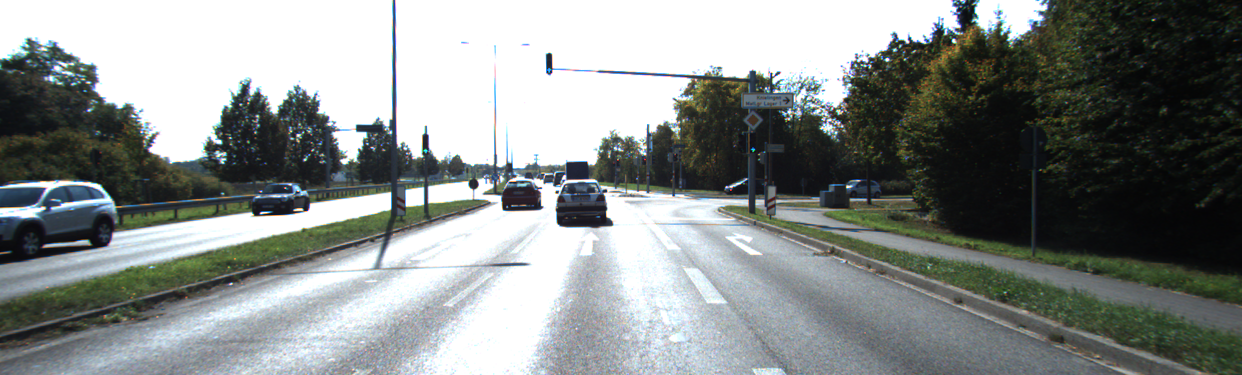

In [4]:
for example in TakeDataset:
    print('--Example--')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']

print('\n--image--')
print(np.shape(image.numpy()))
print('\n--filename')
print(filename)
print('\n--objects--')
print('objects의 type : ', type(objects),'\n')
print(objects)
img = Image.fromarray(image.numpy())
img

KITTI 데이터셋에서 `image` 정보와, `image 이름`, `object`(`bbox` 정보)를 받아와서  
이미지를 `image 이름`.png 형식으로 저장하고 image path와 `bbox`와 클래스 정보를 csv 형식으로  
로컬에 저장하여 모델을 학습시킬 수 있는 데이터셋으로 전처리한다.

### 데이터 포맷 변경
keras RetineNet API를 사용하기 위해 tensorflow_dataset의 KITTI dataset에서 필요한 data(이미지 파일 위치, 바운딩 박스 위치, 클래스 정보)를 CSV 파일 포맷 형태로 바꿔준다.

In [5]:
import os
#일단 미리 다운받을 경로를 지정해둔다.
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data' #csv를 저장할 경로위치
img_dir = os.getenv('HOME')+'/kitti_images' #학습에 사용될 이미지들
train_csv_path = data_dir+'/kitti_train.csv' #CSV 파일

# parse_dataset 함수 구현
def parse_dataset(dataset, img_dir='kitti_images', total=0):
    '''
    dataset : tfds의 ds_train이 들어오게 된다.
    img_dir : img_dir => 이미지를 저장할 위치
    total : tqdm의 인자로 총 반복량을 뜻한다(train example 수, test example 수를 주게된다.)
    '''
    #경로에 폴더 없으면 만들어준다.
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
        
    #기존의 class를 차와 사람으로 나누었다.
    type_class_map = {0:"car",
                     1:"car",
                     2:"car",
                     3:"person",
                     4:"person",
                     5:"person"}
    
    #keras retinanet을 학습하기 위해 dataset을 csv로 parsing하기 위해 필요한 column을 가진
    #pandas.DataFrame을 생성한다.
    df = pd.DataFrame(columns=['img_path', 'x1', 'y1','x2','y2','class_name'])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8') # '**.png'
        img_path = os.path.join(img_dir, filename) # '~/aiffel/kitti_images''/''**.png'
        
        img = Image.fromarray(item['image'].numpy()) # np.array형태로 img 담기
        img.save(img_path) # 위에서 정의한 경로와 파일 이름으로 이미지를 저장하기
        object_bbox = item['objects']['bbox'] # bbox 정보받아오기
        object_type = item['objects']['type'].numpy() # Class 정보 받기
        
        width, height = img.size # 이미지 너비, 높이
        
        #tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel 좌표로 변환한다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        #한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append한다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path" : img_path,
                "x1" : _rect[0],
                "y1" : _rect[1],
                "x2" : _rect[2],
                "y2" : _rect[3],
                "class_name" : type_class_map[_type]
            }, ignore_index=True)
            break
    return df

In [29]:
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False,header=False)

100%|██████████| 6347/6347 [13:16<00:00,  7.97it/s]


In [30]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:34<00:00,  7.54it/s]


In [6]:
class_txt_path = data_dir + '/classes.txt'
def save_class_format(path="./classes.txt"):
    class_type_map = {"car":0, "person":1}
    
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

In [9]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다.
#!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

In [10]:
#!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5